In [1]:
import os
import sys
import json
import importlib
import numpy as np
#import hashlib
#import itertools
#import warnings
import logging
import pandas as pd
#from metrics import get_metrics
#from sklearn import datasets as skl_datasets
#from scenarios import *
from plots import *
from experiments import ResultsEntry

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath('.')))
sys.path.append(PROJECT_ROOT)
#print(PROJECT_ROOT)
#from data_preprocessing.data_interface import get_data_sklearn, DataNotAvailable

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

INFO:/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/data_preprocessing/data_interface.py:ROOT PROJECT FOLDER = /home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter


/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter


In [ ]:
#CONFIG_FILENAME = "example_loop_experiment_config.json"

In [ ]:
#with open(CONFIG_FILENAME, 'r') as f:
#    config = json.loads(f.read())

#datasets = config['datasets']
#classifier_strings = config['classifiers']

#classifiers = {}
#for module_name, class_name in classifier_strings:
#    module = importlib.import_module(module_name)
#    class_ = getattr(module, class_name)
#    classifiers[class_name] = class_

#experiment_params = config['experiment_params']

#results_filename = config['results_filename']

#n_reps = config['n_reps']

#mia_classifier_module, mia_classifier_name = config['mia_classifier']
#module = importlib.import_module(mia_classifier_module)
#mia_classifier = getattr(module, mia_classifier_name)

#scenarios = config['scenarios']

In [2]:
results_filename = "Random_Forest_loop_results.csv"
results_df = pd.read_csv(results_filename)

In [3]:
results_df = results_df[results_df.dataset!="medical-mnist-ab-v-br-100"]

In [4]:
rf_low_auc = results_df[results_df.mia_AUC<0.45]

results_df['target_auc_range'] = 'medium'
results_df.loc[(results_df['target_AUC'] < 0.45 ), 'target_auc_range'] = 'low'
results_df.loc[(results_df['target_AUC'] > 0.65 ), 'target_auc_range'] = 'high'

results_df['mia_auc_range'] = 'medium'
results_df.loc[(results_df['mia_AUC'] < 0.45 ), 'mia_auc_range'] = 'low'
results_df.loc[(results_df['mia_AUC'] > 0.65 ), 'mia_auc_range'] = 'high'


INFO:numexpr.utils:NumExpr defaulting to 4 threads.


target_AUC


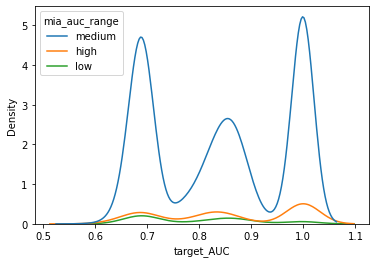

mia_AUC


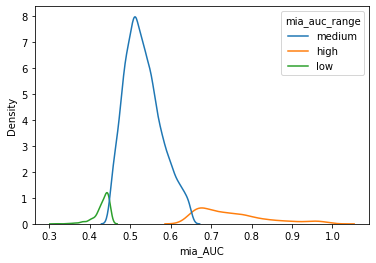

target_FAR


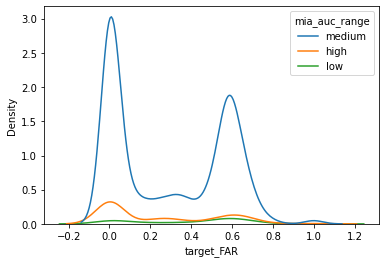

mia_FAR


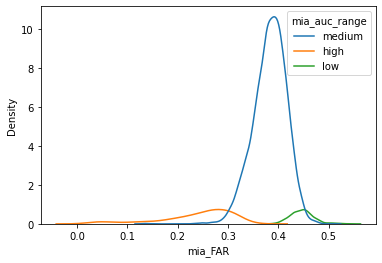

target_Advantage


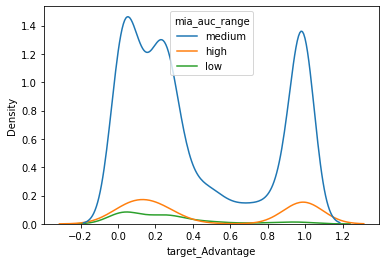

mia_Advantage


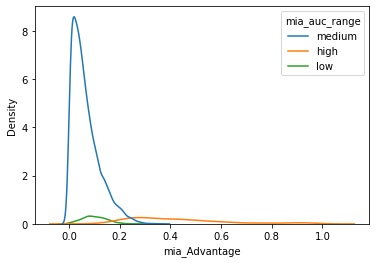

bootstrap


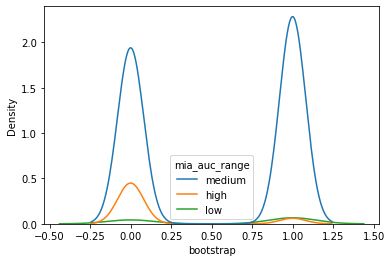

min_samples_split


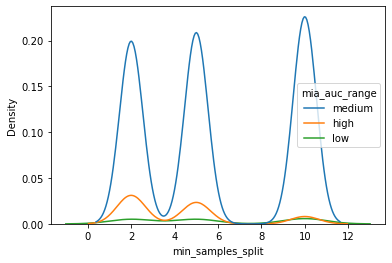

min_samples_leaf


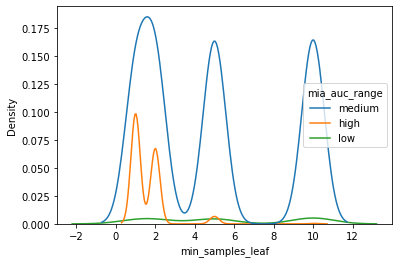

n_estimators


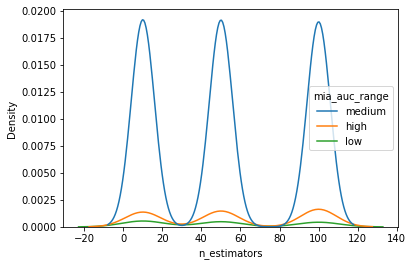

max_depth


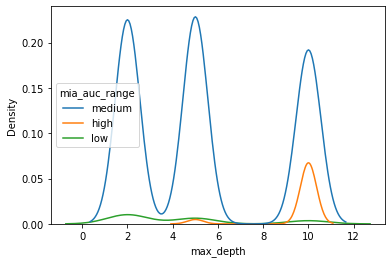

In [6]:
var = ['target_AUC', 'mia_AUC',
           'target_FAR', 'mia_FAR',
           'target_Advantage', 'mia_Advantage',
          'bootstrap','min_samples_split',
           'min_samples_leaf', 'n_estimators',
            'max_depth',
          ]
for v in var:
    print(v)
    sns.kdeplot(data=results_df, x=v,  hue="mia_auc_range")
    plt.show()

In [ ]:
var = ['target_AUC', 'mia_AUC',
           'target_FAR', 'mia_FAR',
           'target_Advantage', 'mia_Advantage',
          'bootstrap','min_samples_split',
           'min_samples_leaf', 'n_estimators',
            'max_depth',
          ]
for v in var:
    print(v)
    sns.kdeplot(data=results_df, x=v,  hue="target_auc_range")
    plt.show()

In [ ]:
rf_low_auc

In [ ]:
results_df

In [ ]:
results_df.auc_range.describe()

In [ ]:
results_df.columns

In [ ]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

sns.set_palette("tab20")

with PdfPages('explore_results_target_mia_RandomForest.pdf') as pdf_pages:
    #df1 = dftest.selemin_samples_splitt_dtypes([np.int, np.float, np.objemin_samples_splitt])
    i = 0
    figu = plt.figure(i)
    #min_samples_splitountplot = sns.min_samples_splitountplot(x=col, data=df1)
    sns.lmplot(
        data=results_df,
        x="mia_AUC", y="target_AUC",
        hue="min_samples_leaf",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_FAR", y="target_FAR",
        hue="min_samples_leaf",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_Advantage", y="target_Advantage",
        hue="min_samples_leaf",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)

    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_AUC", y="target_AUC",
        hue="min_samples_split",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_FAR", y="target_FAR",
        hue="min_samples_split",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_Advantage", y="target_Advantage",
        hue="min_samples_split",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_AUC", y="target_AUC",
        hue="max_depth",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_FAR", y="target_FAR",
        hue="max_depth",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_Advantage", y="target_Advantage",
        hue="max_depth",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)

In [ ]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

with PdfPages('explore_results_simple_randomForest.pdf') as pdf_pages:
    #df1 = dftest.select_dtypes([np.int, np.float, np.object])
    i = 0
    
    figu = plt.figure(i)        
    sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_AUC",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="mia_FAR", y="mia_AUC",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_FAR",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)    
    sns.lmplot(
            data=results_df, x="target_AUC", y="mia_AUC",
            col="scenario"
    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="target_FAR", y="mia_FAR",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="target_Advantage", y="mia_Advantage",
            col="scenario"
    )
    plt.tight_layout()
    pdf_pages.savefig(figu)
    i+=1
    
            
    figu = plt.figure(i)    
    sns.lmplot(
        data=results_df, x="target_AUC", y="mia_AUC",
        hue="dataset", col="scenario"
    )
    i+=1
    ##############
    var = ['bootstrap', 'min_samples_split',
           'min_samples_leaf', 'n_estimators',
           'criterion', 'max_depth',
           'class_weight',
          ]
    for v in var:
        figu = plt.figure(i)        
        sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_AUC",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="mia_FAR", y="mia_AUC",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_FAR",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)    
        sns.lmplot(
            data=results_df, x="target_AUC", y="mia_AUC",
            hue=v, col="scenario"

        )
        
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="target_FAR", y="mia_FAR",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="target_Advantage", y="mia_Advantage",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)
        i+=1

    var = ['target_AUC', 'mia_AUC',
           'target_FAR', 'mia_FAR',
           'target_Advantage', 'mia_Advantage',
          ]
    for v in var:
        figu = plt.figure(i)
        sns.catplot(data=results_df, x="scenario", y=v,
                #hue="scenario", #col="min_samples_split",
                cut=0,
               kind='violin').set_xticklabels(rotation=90)
        plt.tight_layout()
        pdf_pages.savefig(figu)
        i+=1

In [ ]:

#logging.getLogger('matplotlib').setLevel(logging.WARNING)

#sns.set_palette("tab20")

#with PdfPages('explore_results_target_mia_SVC_param_id.pdf') as pdf_pages:
#    #df1 = dftest.select_dtypes([np.int, np.float, np.object])
#    i = 0
#    figu = plt.figure(i)
#    #countplot = sns.countplot(x=col, data=df1)
#    sns.lmplot(
#        data=results_df,
#        x="mia_AUC", y="target_AUC",
#        hue="param_id",
#        col="dataset",
#        row="scenario",
#        height=2.5, aspect=1.5
#    )
#    pdf_pages.savefig(figu)
#    figu = plt.figure(i)
#    sns.lmplot(
#        data=results_df,
#        x="mia_FAR", y="target_FAR",
#        hue="param_id",
#        col="dataset",
#        row="scenario",
#        height=2.5, aspect=1.5
#    )
#    pdf_pages.savefig(figu)
#    figu = plt.figure(i)
#    sns.lmplot(
#        data=results_df,
#        x="mia_Advantage", y="target_Advantage",
#        hue="param_id",
#        col="dataset",
#        row="scenario",
#        height=2.5, aspect=1.5
#    )
#    pdf_pages.savefig(figu)

In [ ]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

with PdfPages('explore_results_tmp.pdf') as pdf_pages:
    #df1 = dftest.select_dtypes([np.int, np.float, np.object])
    i = 0
    figu = plt.figure(i)
        #countplot = sns.countplot(x=col, data=df1)
        
    sns.lmplot(
        data=results_df, x="mia_Advantage", y="mia_AUC",
        hue="min_samples_split", row="scenario", col="dataset",
         
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df, x="mia_FAR", y="mia_AUC",
        hue="min_samples_split", row="scenario", col="dataset",
         
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df, x="mia_Advantage", y="mia_FAR",
        hue="min_samples_split", row="scenario", col="dataset",
         
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)    
    sns.lmplot(
        data=results_df, x="target_AUC", y="mia_AUC",
        hue="min_samples_split", row="scenario", col="dataset",
         
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df, x="target_FAR", y="mia_FAR",
        hue="min_samples_split", row="scenario", col="dataset",
         
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df, x="target_Advantage", y="mia_Advantage",
        hue="min_samples_split", row="scenario", col="dataset",
         
    )

    var = ['target_AUC', 'mia_AUC',
           'target_FAR', 'mia_FAR',
           'target_Advantage', 'mia_Advantage',
          ]
    for v in var:
    
        i+=1
        figu = plt.figure(i)
        sns.catplot(data=results_df, x="min_samples_split", y=v,
                hue="scenario", col="dataset", #row="min_samples_split",
                cut=0,
               kind='violin').set_xticklabels(rotation=90)
        pdf_pages.savefig(figu)

In [ ]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

with PdfPages('explore_results_simple_randomForest.pdf') as pdf_pages:
    #df1 = dftest.select_dtypes([np.int, np.float, np.object])
    i = 0
    
    figu = plt.figure(i)        
    sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_AUC",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="mia_FAR", y="mia_AUC",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_FAR",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)    
    sns.lmplot(
            data=results_df, x="target_AUC", y="mia_AUC",
            col="scenario"
    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="target_FAR", y="mia_FAR",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="target_Advantage", y="mia_Advantage",
            col="scenario"
    )
    plt.tight_layout()
    pdf_pages.savefig(figu)
    i+=1
    
            
    figu = plt.figure(i)    
    sns.lmplot(
        data=results_df, x="target_AUC", y="mia_AUC",
        hue="dataset", col="scenario"
    )
    i+=1
    ##############
    var = ['bootstrap', 'min_samples_split',
           'min_samples_leaf', 'n_estimators',
           'criterion', 'max_depth',
           'class_weight',
          ]
    for v in var:
        figu = plt.figure(i)        
        sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_AUC",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="mia_FAR", y="mia_AUC",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_FAR",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)    
        sns.lmplot(
            data=results_df, x="target_AUC", y="mia_AUC",
            hue=v, col="scenario"

        )
        
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="target_FAR", y="mia_FAR",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="target_Advantage", y="mia_Advantage",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)
        i+=1

    var = ['target_AUC', 'mia_AUC',
           'target_FAR', 'mia_FAR',
           'target_Advantage', 'mia_Advantage',
          ]
    for v in var:
        figu = plt.figure(i)
        sns.catplot(data=results_df, x="scenario", y=v,
                #hue="scenario", #col="min_samples_split",
                cut=0,
               kind='violin').set_xticklabels(rotation=90)
        plt.tight_layout()
        pdf_pages.savefig(figu)
        i+=1

In [ ]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

with PdfPages('explore_results_simple_randomForest_MIA_rangeAUC.pdf') as pdf_pages:
    #df1 = dftest.select_dtypes([np.int, np.float, np.object])
    i = 0
    
    figu = plt.figure(i)        
    sns.lmplot(
            data=rf_low_auc, x="mia_Advantage", y="mia_AUC",
            col="auc_range"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)        
    sns.kdeplot(
            data=rf_low_auc, y="mia_AUC",
            hue="auc_range"
    )
    plt.tight_layout()
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=rf_low_auc, x="mia_FAR", y="mia_AUC",
            col="auc_range"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=rf_low_auc, x="mia_Advantage", y="mia_FAR",
            col="auc_range"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)    
    sns.lmplot(
            data=rf_low_auc, x="target_AUC", y="mia_AUC",
            col="auc_range"
    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=rf_low_auc, x="target_FAR", y="mia_FAR",
            col="auc_range"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=rf_low_auc, x="target_Advantage", y="mia_Advantage",
            col="auc_range"
    )
    plt.tight_layout()
    pdf_pages.savefig(figu)
    i+=1
    
            
    figu = plt.figure(i)    
    sns.lmplot(
        data=rf_low_auc, x="target_AUC", y="mia_AUC",
        hue="dataset", col="auc_range"
    )
    i+=1
    ##############
    var = ['bootstrap', 'min_samples_split',
           'min_samples_leaf', 'n_estimators',
           'criterion', 'max_depth',
           'class_weight',
          ]
    for v in var:
        figu = plt.figure(i)        
        sns.lmplot(
            data=rf_low_auc, x="mia_Advantage", y="mia_AUC",
            hue=v, col="auc_range"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=rf_low_auc, x="mia_FAR", y="mia_AUC",
            hue=v, col="auc_range"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=rf_low_auc, x="mia_Advantage", y="mia_FAR",
            hue=v, col="auc_range"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)    
        sns.lmplot(
            data=rf_low_auc, x="target_AUC", y="mia_AUC",
            hue=v, col="auc_range"

        )
        
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=rf_low_auc, x="target_FAR", y="mia_FAR",
            hue=v, col="auc_range"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=rf_low_auc, x="target_Advantage", y="mia_Advantage",
            hue=v, col="auc_range"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)
        i+=1

    var = ['target_AUC', 'mia_AUC',
           'target_FAR', 'mia_FAR',
           'target_Advantage', 'mia_Advantage',
          ]
    for v in var:
        figu = plt.figure(i)
        sns.catplot(data=rf_low_auc, x="auc_range", y=v,
                #hue="auc_range", #col="min_samples_split",
                cut=0,
               kind='violin').set_xticklabels(rotation=90)
        plt.tight_layout()
        pdf_pages.savefig(figu)
        i+=1

In [ ]:
results_filename = "/home/alba/Documents/HIC_Dundee/GRAIMAtter/SVC_rbf_results.csv"
results_df = pd.read_csv(results_filename)
results_df = results_df[results_df.dataset!="medical-mnist-ab-v-br-100"]

logging.getLogger('matplotlib').setLevel(logging.WARNING)

sns.set_palette("tab20")

with PdfPages('explore_results_target_mia_SVC.pdf') as pdf_pages:
    #df1 = dftest.select_dtypes([np.int, np.float, np.object])
    i = 0
    figu = plt.figure(i)
    #countplot = sns.countplot(x=col, data=df1)
    sns.lmplot(
        data=results_df,
        x="mia_AUC", y="target_AUC",
        hue="gamma",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_FAR", y="target_FAR",
        hue="gamma",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_Advantage", y="target_Advantage",
        hue="gamma",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)

    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_AUC", y="target_AUC",
        hue="C",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_FAR", y="target_FAR",
        hue="C",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_Advantage", y="target_Advantage",
        hue="C",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_AUC", y="target_AUC",
        hue="tol",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_FAR", y="target_FAR",
        hue="tol",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.lmplot(
        data=results_df,
        x="mia_Advantage", y="target_Advantage",
        hue="tol",
        col="dataset",
        row="scenario",
        height=2.5, aspect=1.5
    )
    pdf_pages.savefig(figu)

In [ ]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

with PdfPages('explore_results_simple_SVC.pdf') as pdf_pages:
    #df1 = dftest.select_dtypes([np.int, np.float, np.object])
    i = 0

    figu = plt.figure(i)        
    sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_AUC",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="mia_FAR", y="mia_AUC",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_FAR",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)    
    sns.lmplot(
            data=results_df, x="target_AUC", y="mia_AUC",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
            data=results_df, x="target_FAR", y="mia_FAR",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)

    i+=1
    figu = plt.figure(i)
    sns.lmplot(
           data=results_df, x="target_Advantage", y="mia_Advantage",
            col="scenario"

    )
    plt.tight_layout()
    pdf_pages.savefig(figu)
    i+=1
    ##############
    var = ['gamma', 'tol', 'C']
    
    for v in var:
        figu = plt.figure(i)        
        sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_AUC",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="mia_FAR", y="mia_AUC",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="mia_Advantage", y="mia_FAR",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)    
        sns.lmplot(
            data=results_df, x="target_AUC", y="mia_AUC",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="target_FAR", y="mia_FAR",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)

        i+=1
        figu = plt.figure(i)
        sns.lmplot(
            data=results_df, x="target_Advantage", y="mia_Advantage",
            hue=v, col="scenario"

        )
        plt.tight_layout()
        pdf_pages.savefig(figu)
        i+=1

    var = ['target_AUC', 'mia_AUC',
           'target_FAR', 'mia_FAR',
           'target_Advantage', 'mia_Advantage',
          ]
    for v in var:
        figu = plt.figure(i)
        sns.catplot(data=results_df, x="scenario", y=v,
                #hue="scenario", #col="min_samples_split",
                cut=0,
               kind='violin').set_xticklabels(rotation=90)
        plt.tight_layout()
        pdf_pages.savefig(figu)
        i+=1

In [ ]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)

with PdfPages('explore_results_tmp_SVC.pdf') as pdf_pages:
    #df1 = dftest.select_dtypes([np.int, np.float, np.object])
    i = 0
    figu = plt.figure(i)
        #countplot = sns.countplot(x=col, data=df1)
        
    sns.relplot(
        data=results_df, x="mia_Advantage", y="mia_AUC",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.relplot(
        data=results_df, x="mia_FAR", y="mia_AUC",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.relplot(
        data=results_df, x="mia_Advantage", y="mia_FAR",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)    
    sns.relplot(
        data=results_df, x="target_AUC", y="mia_AUC",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.relplot(
        data=results_df, x="target_FAR", y="mia_FAR",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )
    pdf_pages.savefig(figu)
    
    i+=1
    figu = plt.figure(i)
    sns.relplot(
        data=results_df, x="target_Advantage", y="mia_Advantage",
        hue="target_classifier", style="scenario", col="dataset",
        kind="scatter", alpha=0.3
    )

    var = ['target_AUC', 'mia_AUC',
           'target_FAR', 'mia_FAR',
           'target_Advantage', 'mia_Advantage',
          ]
    for v in var:
    
        i+=1
        figu = plt.figure(i)
        sns.catplot(data=results_df, x="target_classifier", y=v,
                hue="scenario", col="dataset", #row="target_classifier",
                cut=0,
               kind='violin').set_xticklabels(rotation=90)
        pdf_pages.savefig(figu)

In [ ]:
sns.relplot(
    data=results_df, x="target_AUC", y="mia_AUC",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)
sns.relplot(
    data=results_df, x="target_FAR", y="mia_FAR",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)
sns.relplot(
    data=results_df, x="target_Advantage", y="mia_Advantage",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)

In [ ]:
var = ['target_AUC', 'mia_AUC',
       'target_FAR', 'mia_FAR',
       'target_Advantage', 'mia_Advantage',
      ]
for v in var:
    sns.catplot(data=results_df, x="target_classifier", y=v,
            hue="scenario", col="dataset", #row="target_classifier",
            cut=0,
           kind='violin').set_xticklabels(rotation=90)